In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import collections
from scipy.spatial import ConvexHull
from scripts.plot import plot_from_files

def counts(data):
    return sorted(collections.Counter(data).items())

def head_and_tail(xs, n=5):
    if len(xs) <= 2*n:
        return xs
    return xs[:n] + ["..."] + xs[-n:]


In [2]:
def load_stats(path):
    return pd.read_table(path, names=['k', 'n', 'c', 'min', 'max', 'star'], sep=' ')

def load_k(k, path):
    if k == 4:
        return pd.read_table(path, names=['n', 'a', 'b1', 'b2'], sep=' ')
    if k == 5:
        return pd.read_table(path, names=['n', 'a', 'b1', 'b2', 'b3', 'b4', 'b5'], sep=' ')
    if k == 6:
        return pd.read_table(path, names=['n', 'a', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'c1', 'c2', 'c3', 'd1', 'd2', 'd3', 'e1', 'e2'], sep=' ')
    raise NotImplementedError

def load_sym_sums(k, path):
    if k == 4:
        return pd.read_table(path, names=['n', 'a', 'b'], sep=' ')
    if k == 5:
        return pd.read_table(path, names=['n', 'a', 'b'], sep=' ')
    if k == 6:
        return pd.read_table(path, names=['n', 'a', 'b', 'c', 'd', 'e'], sep=' ')
    raise NotImplementedError

In [3]:
def remove_float_xticks():
    filtered = [t for t in plt.xticks()[0] if math.isclose(t, round(t))]
    plt.xticks(np.array(filtered))

def plot_stats_histograms(df, v):
    df_v = df[df.k + df.n == v]
    min_k, max_k = df_v.k.min(), df_v.k.max()
    for k in range(min_k, max_k + 1):
        fig = plt.figure(figsize=(25, 2.5))
        fig.suptitle('n+k = {}, k = {}'.format(v, k))
        fig.tight_layout()
        attrs = [
            ('c', 'number of coefficients'),
            ('star', 'star coefficient value'),
        ]
        for attr_i, (attr, title) in enumerate(attrs):
            df_selected = df_v[df_v.k == k][attr]
            min_, max_ = df_selected.min(), df_selected.max()
            plt.subplot(1, 2, attr_i + 1)
            plt.title(title)
            df_selected.plot.hist(bins=np.arange(min_, max_ + 2)-0.5, logy=True, ylim=(1e-1, 1e8))
            plt.yticks(10 ** np.arange(0, 8))
            plt.grid(axis='y')
            remove_float_xticks()
        plt.show()
        print('star coefficient value counts:', *head_and_tail(counts(df_v[df_v.k == k].star)))
        print('----------')


# Flow Polynomial Coeffcients (Bridges Allowed)

`k` = number of outer vertices \
`n` = number of inner vertices \
star coefficient = the coeffcient with all outer vertices connected

In [4]:
df_stats_c2m2dP = load_stats('computed/each-stats-c2m2dP-26.txt.gz')


In [5]:
# plot_stats_histograms(df_stats_c2m2dP, 26)


# Flow Polynomial Coeffcients (Bridges Forbidden)

`k` = number of outer vertices \
`n` = number of inner vertices \
star coefficient = the coeffcient with all outer vertices connected

In [6]:
df_stats_dP = load_stats('computed/each-stats-dP-26.txt.gz')


In [7]:
# plot_stats_histograms(df_stats_dP, 26)


# The Bridgeless 3-pole, 4-pole, and 5-pole With the Largest Star Coefficient Value

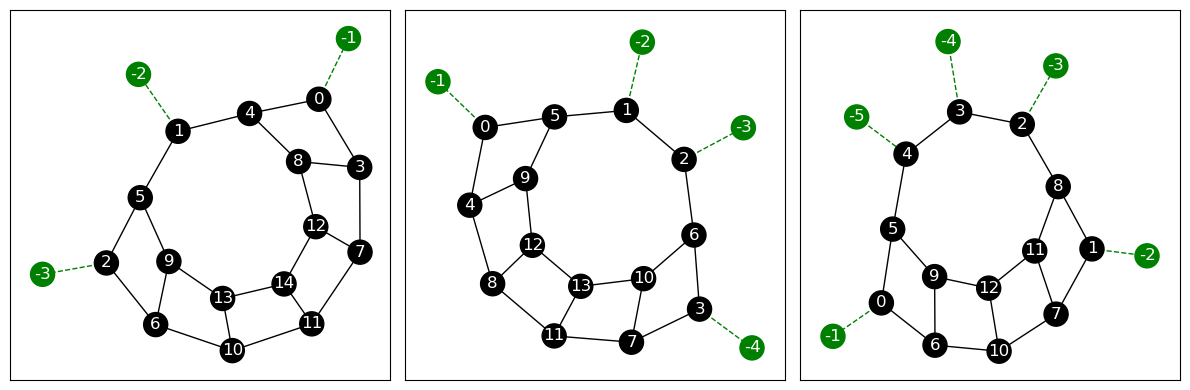

In [8]:
plot_from_files([
    'graphs/max_star/3-18.txt',
    'graphs/max_star/4-18.txt',
    'graphs/max_star/5-18.txt',
])


---

In [9]:
def plot_k4(df, v):
    df_v = df[4 + df.n == v]
    df_agg = df_v.groupby(['a', 'b1', 'b2']).size().reset_index(name='cnt')
    df_agg['colorings'] = 21*df_agg.a + 9*(df_agg.b1 + df_agg.b2)

    a, b1, b2 = df_agg.a, df_agg.b1, df_agg.b2

    assert (a >= 0).all()
    assert (a + b1 >= 0).all()
    assert (a + b2 >= 0).all()
    assert (a + b1 + b2 >= 0).all()

    fig = plt.figure(figsize=(12, 6))
    fig.suptitle('n+k = {}, k = 4'.format(v))

    xs, ys, zs = a, b1, b2
    ax = fig.add_subplot(121, projection='3d')
    ax.set_xlabel('star value')
    ax.set_ylabel('second value')
    ax.set_zlabel('third value')
    min_ = min(xs.min(), ys.min(), zs.min())-5
    max_ = max(xs.max(), ys.max(), zs.max())+5
    ax.set_xlim(min_, max_)
    ax.set_ylim(min_, max_)
    ax.set_zlim(min_, max_)
    ax.set_aspect('equal')
    ax.scatter(xs, ys, zs, c=df_agg.cnt, cmap='copper', norm=mpl.colors.LogNorm(), s=5)
    ax.view_init(15, -135)

    xs, ys = a, b1 + b2
    ax = fig.add_subplot(122)
    ax.set_xlabel('star value')
    ax.set_ylabel('second value + third value')
    min_ = min(xs.min(), ys.min())-5
    max_ = max(xs.max(), ys.max())+5
    ax.set_xlim(min_, max_)
    ax.set_ylim(min_, max_)
    ax.set_aspect('equal')
    ax.scatter(xs, ys, c=df_agg.cnt, cmap='copper', norm=mpl.colors.LogNorm(), s=5)

    lsp = np.linspace(min_, max_, 500)
    X, Y = np.meshgrid(lsp, lsp)
    Z = 21*X + 9*Y
    Z[(X < 0) | (X + Y < 0)] = np.nan
    ax.imshow(Z, extent=[min_, max_, min_, max_], cmap='Greens', origin='lower')
    ax.axline((0, 0), slope=9/21, color='k', linestyle='--', linewidth=0.5)
    ax.text(max_-5, max_-5, 'color stregth = number of colorings\ndotted line = max gradient', ha='right', va='top')

    plt.grid()
    plt.tight_layout()
    plt.show()

    return df_agg.sort_values(by='colorings')


# Coeffcient Values for $k=4$ (Bridges Allowed)

In [10]:
df_k4_c2m2dP4 = load_k(4, 'computed/each-k4-c2m2dP4-26.txt.gz')


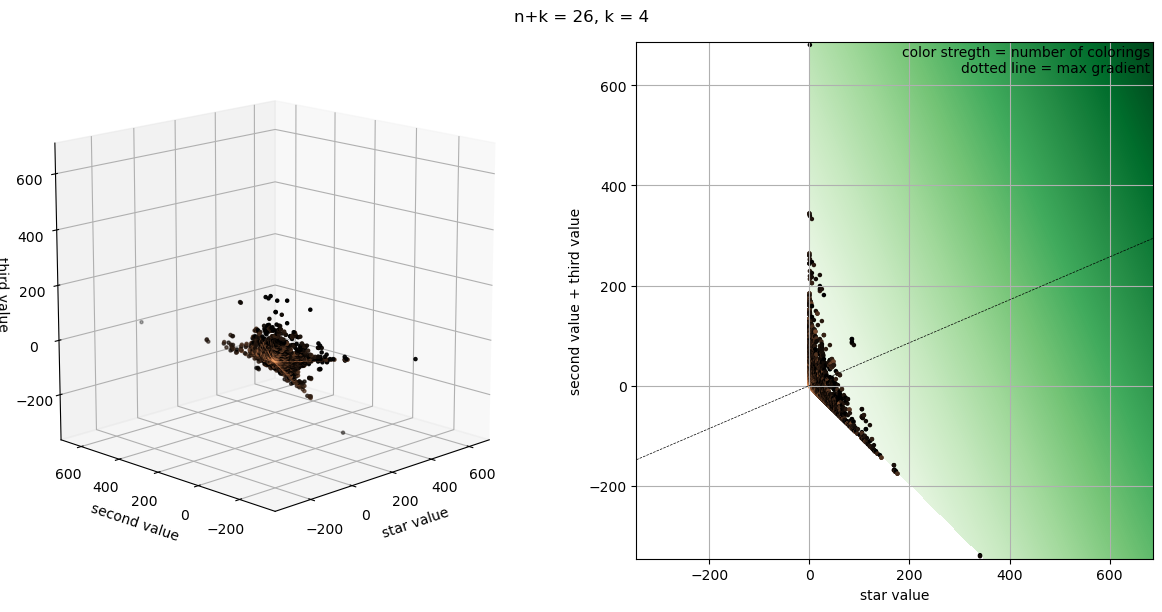

,a,b1,b2,cnt,colorings
302,1,-1,0,812857,12
307,1,0,-1,195579,12
0,0,1,1,325390,18
648,2,-2,0,39248,24
661,2,0,-2,13475,24
...,...,...,...,...,...
300,0,340,4,4,3096
1977,5,338,-5,4,3102
9228,341,0,-341,2,4092
9227,341,-341,2,1,4110


In [11]:
plot_k4(df_k4_c2m2dP4, 26)


# Coeffcient Values for $k=4$ (Bridges Forbidden)

In [12]:
df_k4_dP4 = load_k(4, 'computed/each-k4-dP4-26.txt.gz')


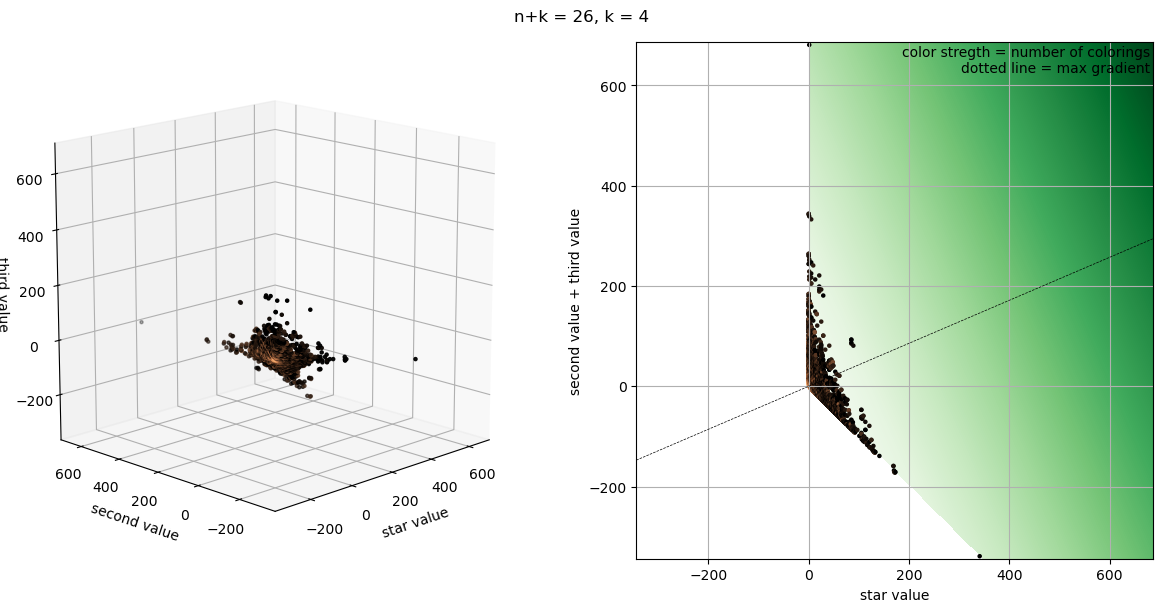

,a,b1,b2,cnt,colorings
0,0,1,1,325390,18
653,2,-1,-1,33887,24
307,1,0,1,33325,30
312,1,1,0,2555,30
319,1,2,-1,272431,30
...,...,...,...,...,...
296,0,172,172,2,3096
301,0,340,4,4,3096
1970,5,338,-5,4,3102
9065,341,-341,2,1,4110


In [13]:
plot_k4(df_k4_dP4, 26)


# The Bridgeless 4-pole With the Largest Number of Colorings

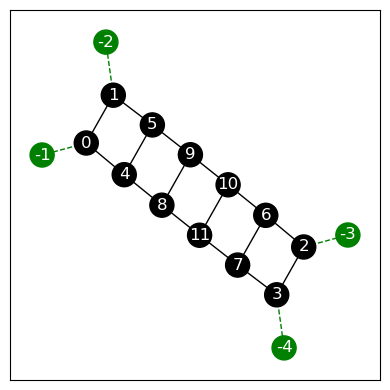

In [14]:
plot_from_files(['graphs/k4_max_colorings/16.txt'])


---

In [15]:
def plot_k5(df, v):
    df_v = df[5 + df.n == v]
    df_agg = df_v.groupby(['a', 'b1', 'b2', 'b3', 'b4', 'b5']).size().reset_index(name='cnt')
    a, b1, b2, b3, b4, b5 = df_agg.a, df_agg.b1, df_agg.b2, df_agg.b3, df_agg.b4, df_agg.b5

    for expr in [
        a + b1,   a + b1 + b2,
        a + b2,   a + b2 + b3,
        a + b3,   a + b3 + b4,
        a + b4,   a + b4 + b5,
        a + b5,   a + b5 + b1,
    ]:
        assert (expr >= 0).all()

    fig = plt.figure(figsize=(6, 6))
    fig.suptitle('n+k = {}, k = 5'.format(v))

    xs, ys = a, b1 + b2 + b3 + b4 + b5
    ax = fig.add_subplot(111)
    ax.set_xlabel('star value')
    ax.set_ylabel('sum of other values')
    min_ = min(xs.min(), ys.min())-5
    max_ = max(xs.max(), ys.max())+5
    ax.set_xlim(min_, max_)
    ax.set_ylim(min_, max_)
    ax.set_aspect('equal')
    ax.scatter(xs, ys, c=df_agg.cnt, cmap='copper', norm=mpl.colors.LogNorm(), s=5)

    ax.plot([0, -1000], [0, 5000], color='g')
    ax.plot([0, 1000], [0, -2500], color='r')
    ax.plot([0, 1000], [0, -2000], color='y')

    plt.grid()
    plt.tight_layout()
    plt.show()

    return df_agg


# Coeffcient Values for $k=5$ (Bridges Allowed)

In [16]:
df_k5_c2m2dP5 = load_k(5, 'computed/each-k5-c2m2dP5-26.txt.gz')


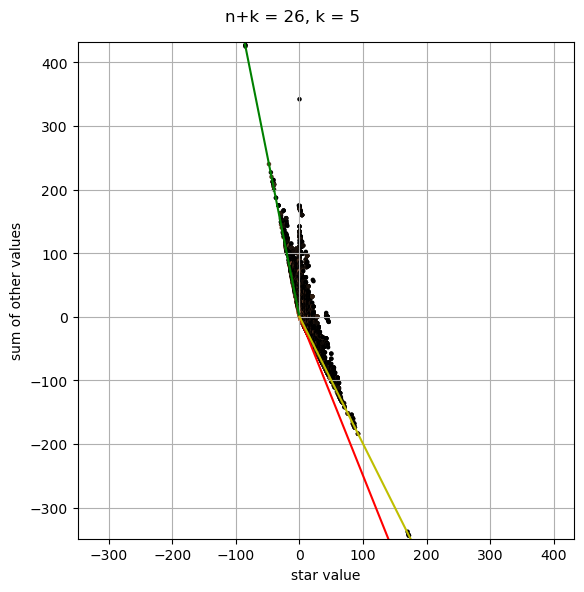

,a,b1,b2,b3,b4,b5,cnt
0,-85,85,85,85,85,85,2
1,-85,85,85,85,85,87,1
2,-85,87,85,85,85,85,1
3,-48,48,48,48,48,48,36
4,-45,45,45,45,45,47,2
...,...,...,...,...,...,...,...
41638,170,0,-170,1,1,-170,1
41639,171,-170,0,-171,0,-1,2
41640,172,-172,0,-172,0,0,3
41641,172,-172,0,0,-172,0,1


In [17]:
plot_k5(df_k5_c2m2dP5, 26)


# Coeffcient Values for $k=5$ (Bridges Forbidden)

In [18]:
df_k5_dP5 = load_k(5, 'computed/each-k5-dP5-26.txt.gz')


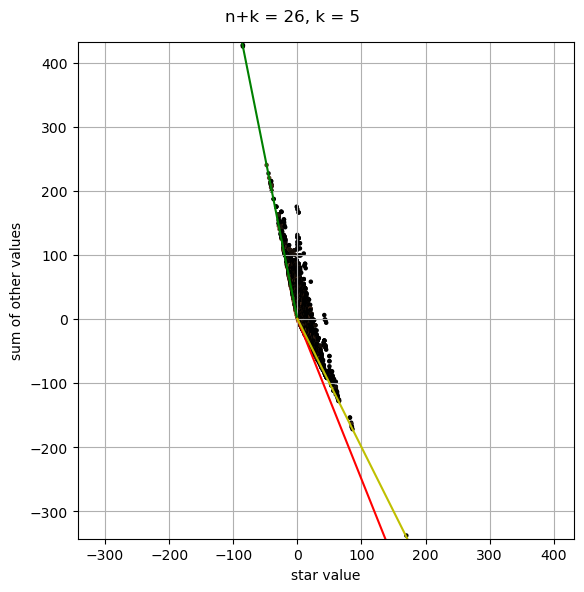

,a,b1,b2,b3,b4,b5,cnt
0,-85,85,85,85,85,85,2
1,-85,85,85,85,85,87,1
2,-85,87,85,85,85,85,1
3,-48,48,48,48,48,48,36
4,-45,45,45,45,45,47,2
...,...,...,...,...,...,...,...
29341,85,-85,0,0,-85,1,1
29342,85,-85,1,-85,0,0,9
29343,85,-85,2,-84,-1,0,1
29344,86,0,-1,-85,-1,-85,1


In [19]:
plot_k5(df_k5_dP5, 26)


# General Constraint Analysis

In [20]:
def unique_rows(df):
    return df.drop_duplicates(ignore_index=True)

def prepare_points(k, v=26, flags='c2m2'):
    path = f'computed/unique-k{k}ss-{flags}dP{k}-{max(v, 16)}.txt.gz'
    df = load_sym_sums(k, path)
    df = df[k + df.n == v]
    df = df.drop(columns='n')
    df = unique_rows(df)
    return df

def get_planes(points):
    hull = ConvexHull(points)
    planes = pd.DataFrame(hull.equations)
    planes = unique_rows(planes)
    planes.columns = points.columns.tolist() + ['offset']
    return planes

def my_isclose(a, b):
    return np.isclose(a, b, atol=1e-6)

def get_zero_offset_planes(planes):
    planes = planes[my_isclose(planes['offset'], 0)].reset_index(drop=True)
    planes = planes.drop(columns='offset')
    # scale each equation so that the first non-zero coefficient is 1
    planes = planes.apply(lambda row: row / row[row != 0].iloc[0], axis=1)
    # rounds coefficients to 0 if they are close to 0
    planes = planes.applymap(lambda x: 0.0 if my_isclose(x, 0) else x)
    planes = unique_rows(planes)
    # sort rows primarily by their sum and secondarily by their value
    planes = planes.assign(sum=planes.sum(axis=1))
    planes = planes.sort_values(['sum'] + planes.columns.tolist())
    planes = planes.drop(columns='sum').reset_index(drop=True)
    return planes

points = prepare_points(4)
planes = get_planes(points)
zero_offset_planes = get_zero_offset_planes(planes)
zero_offset_planes

,a,b
0,1.0,0.0
1,1.0,1.0


In [21]:
points = prepare_points(5)
planes = get_planes(points)
zero_offset_planes = get_zero_offset_planes(planes)
zero_offset_planes

,a,b
0,1.0,0.2
1,1.0,0.5


In [22]:
points = prepare_points(6)
planes = get_planes(points)
zero_offset_planes = get_zero_offset_planes(planes)
zero_offset_planes

,a,b,c,d,e
0,1.0,0.333333,0.000000,0.000000,0.000000
1,1.0,0.317190,0.021524,0.162900,-0.016143
2,1.0,0.371996,0.016184,-0.032369,0.140265
3,1.0,0.316889,0.021926,0.197076,-0.016445
4,1.0,0.417783,0.017675,-0.035351,0.153187
5,1.0,0.268874,0.119205,0.184106,-0.014570
6,1.0,0.319853,0.149510,0.136029,-0.013480
7,1.0,0.119881,0.421445,0.082651,-0.008191
8,1.0,0.247444,0.166053,0.217996,-0.008589
9,1.0,0.086042,0.490373,0.063710,-0.006314
